In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

batch_size = 64

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

# Transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor()
    ])

# MNIST dataset
train_dataset = datasets.MNIST(root = "./data/", 
                               train = True, 
                               transform = transform,
                               download = True)

test_dataset = datasets.MNIST(root = "./data/",
                              train = False,
                              transform = transform)


# Train indices for validation
validation_size = 0.2

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, validation_idx = indices[split:], indices[:split]

# Samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)
 
# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           sampler = train_sampler)

validation_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                                batch_size = batch_size,
                                                sampler = validation_sampler)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

''' 
ex = iter(train_loader).next()
ex[0].shape
'''

' \nex = iter(train_loader).next()\nex[0].shape\n'

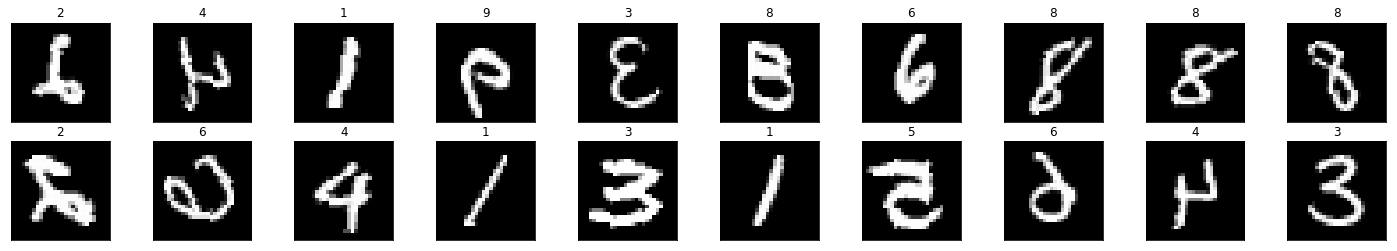

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [9]:
# Create swish function
from torch.autograd import Function
from torch.nn.parameter import Parameter

def swish(input):
    return input * torch.sigmoid(input)

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
        
    def forward(self, input):
        return swish(input)

In [10]:
# Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 3)
        self.conv3 = nn.Conv2d(20, 30, kernel_size = 3)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(30, 20)
        self.fc2 = nn.Linear(20, 10)
        
        self.dropout1 = nn.Dropout(p = 0.2)
        self.dropout2 = nn.Dropout(p = 0.4)
        
    def forward(self, x):
        in_size = x.size(0)
        
        out = swish(self.maxpool(self.conv1(x)))
        out = swish(self.maxpool(self.conv2(out)))
        out = swish(self.maxpool(self.conv3(out)))
        
        out = out.view(in_size, -1)
        
        out = self.dropout1(out)
        
        out = swish(self.fc1(out))
        
        out = self.dropout2(out)
        
        out = self.fc2(out)
        return out
    
model = Net()

if use_cuda:
    model.cuda()

/home/cuausuarez/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU0 GeForce GTX 870M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [11]:
# Loss and optimizers
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

In [12]:
# train model

n_epochs = 30

validation_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):
    
    # Track loss
    train_loss = 0.0
    validation_loss = 0.0
    
    #########
    # Train #
    #########
    model.train()
    
    for data, target in train_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item() * data.size(0)
            
    ############
    # Validate #
    ############
    model.eval()

    for data, target in validation_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        loss = criterion(output, target)

        validation_loss += loss.item() * data.size(0)

    # Average losses
    train_loss = train_loss / len(train_loader.sampler)
    validation_loss = validation_loss / len(validation_loader.sampler)

    print("Epoch: {} \tTraining Loss {:.6f} \tValidation Loss: {:.6f}".format( 
          epoch, train_loss, validation_loss))

    # Save model
    if validation_loss <= validation_loss_min:
        print("Validation loss decreased from {:.6f} to {:.6f}. Saving model!".format(
             validation_loss_min,
             validation_loss))

        torch.save(model.state_dict(), 'model_mnist.pt')
        validation_loss_min = validation_loss

Epoch: 1 	Training Loss 2.271020 	Validation Loss: 1.635013
Validation loss decreased from inf to 1.635013. Saving model!
Epoch: 2 	Training Loss 1.052034 	Validation Loss: 0.578856
Validation loss decreased from 1.635013 to 0.578856. Saving model!
Epoch: 3 	Training Loss 0.687932 	Validation Loss: 0.407287
Validation loss decreased from 0.578856 to 0.407287. Saving model!
Epoch: 4 	Training Loss 0.568072 	Validation Loss: 0.322811
Validation loss decreased from 0.407287 to 0.322811. Saving model!
Epoch: 5 	Training Loss 0.494737 	Validation Loss: 0.264706
Validation loss decreased from 0.322811 to 0.264706. Saving model!
Epoch: 6 	Training Loss 0.433639 	Validation Loss: 0.238519
Validation loss decreased from 0.264706 to 0.238519. Saving model!
Epoch: 7 	Training Loss 0.404708 	Validation Loss: 0.231005
Validation loss decreased from 0.238519 to 0.231005. Saving model!
Epoch: 8 	Training Loss 0.371949 	Validation Loss: 0.217952
Validation loss decreased from 0.231005 to 0.217952. Sav

In [13]:
# Load model with lowest validation loss
model.load_state_dict(torch.load('model_mnist.pt'), strict = False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
model.state_dict()

OrderedDict([('conv1.weight', tensor([[[[ 0.2078, -0.4234, -0.9413],
                        [-0.6778, -0.0064,  0.3089],
                        [-0.8366, -0.0190,  0.8278]]],
              
              
                      [[[ 0.4194, -0.3224, -0.8077],
                        [ 0.8938,  0.3903, -1.1121],
                        [ 0.8251, -0.4956, -1.0328]]],
              
              
                      [[[ 0.1737,  0.0860,  0.2198],
                        [ 0.0352, -0.0606,  0.1698],
                        [ 0.2603,  0.2646,  0.3119]]],
              
              
                      [[[-0.6985, -0.9129, -0.5467],
                        [ 0.2243, -0.0689, -1.1157],
                        [ 0.7689,  0.8681,  0.3506]]],
              
              
                      [[[-0.0919, -0.7920, -0.1852],
                        [-0.8336, -0.4799,  0.7122],
                        [ 0.1597,  0.7769,  0.7203]]],
              
              
                      [[[-1.0

In [15]:
# Test network
model.eval()
test_loss = 0.0
correct = 0

for data, target in test_loader:
    if use_cuda:
        data, target = data.cuda(), target.cuda()
        
    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item() * data.size(0)
    
    _, pred = torch.max(output, 1)
    
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

# Average
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

print("Accuracy: {}/{} ({:.2f}%)\n".format(
    correct, len(test_loader.dataset), 
    100. * correct / len(test_loader.dataset)))

Test Loss: 0.112776

Accuracy: 9655/10000 (96.00%)

